# Importing packages

In [1]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, preprocessing
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### reading pkl file for parsed data

In [179]:
df = pd.read_csv('parsed_data.csv')
df = df.iloc[:, 1:]


In [180]:
print(df.head())

           Gene ID    Transcript ID  Position     N1     N2     N3  \
0  ENSG00000004059  ENST00000000233       244  AAGAC  AGACC  GACCA   
1  ENSG00000004059  ENST00000000233       261  CAAAC  AAACT  AACTG   
2  ENSG00000004059  ENST00000000233       316  GAAAC  AAACA  AACAG   
3  ENSG00000004059  ENST00000000233       332  AGAAC  GAACA  AACAT   
4  ENSG00000004059  ENST00000000233       368  AGGAC  GGACA  GACAA   

   N1 Avg Length  N1 Min Length  N1 Max Length  N1 Median Length  ...  \
0       0.008264        0.00199         0.0339           0.00697  ...   
1       0.006609        0.00199         0.0222           0.00564  ...   
2       0.007570        0.00232         0.0299           0.00631  ...   
3       0.010620        0.00232         0.0370           0.00902  ...   
4       0.010701        0.00199         0.0478           0.00896  ...   

   N3 Median Length  N3 Avg SD  N3 Min SD  N3 Max SD  N3 Median SD  \
0          0.005980   4.386989      0.773      15.50         3.440   


In [3]:
print(df.shape)


(121838, 43)


In [183]:
# List of columns to normalize
columns_to_normalize = ['N1 Avg Length', 'N1 Min Length', 'N1 Max Length', 'N1 Median Length', 'N1 Avg SD', 'N1 Min SD', 'N1 Max SD', 'N1 Median SD', 'N1 Avg Mean', 'N1 Min Mean', 'N1 Max Mean',
                         'N1 Median Mean', 'N2 Avg Length', 'N2 Min Length', 'N2 Max Length', 'N2 Median Length', 'N2 Avg SD', 'N2 Min SD', 'N2 Max SD', 'N2 Median SD', 'N2 Avg Mean', 
                         'N2 Min Mean', 'N2 Max Mean', 'N2 Median Mean', 'N3 Avg Length', 'N3 Min Length', 'N3 Max Length', 'N3 Median Length', 'N3 Avg SD', 'N3 Min SD', 'N3 Max SD', 
                         'N3 Median SD', 'N3 Avg Mean', 'N3 Min Mean', 'N3 Max Mean', 'N3 Median Mean']


# Ensure columns are numeric
df[columns_to_normalize] = df[columns_to_normalize].apply(pd.to_numeric, errors='coerce')

# Define the normalization function
def safe_min_max(x):
    min_val = x.min()
    max_val = x.max()
    if max_val != min_val:
        return (x - min_val) / (max_val - min_val)
    else:
        return 0  # or x * 0 to keep the same shape

# Apply normalization grouped by 'Gene ID' and 'Transcript ID'
# If 'Gene ID' is available in your DataFrame
df[columns_to_normalize] = df.groupby(['Gene ID', 'Transcript ID'])[columns_to_normalize].transform(safe_min_max)

# If 'Gene ID' is not available, group by 'Transcript ID' only
# data_df[columns_to_normalize] = data_df.groupby(['Transcript ID'])[columns_to_normalize].transform(safe_min_max)

# (Optional) Reset index if needed
# data_df = data_df.reset_index(drop=True)

# (Optional) Handle missing values
df[columns_to_normalize] = df[columns_to_normalize].fillna(0)

# Display the normalized DataFrame
print(df.head())


           Gene ID    Transcript ID  Position     N1     N2     N3  \
0  ENSG00000004059  ENST00000000233       244  AAGAC  AGACC  GACCA   
1  ENSG00000004059  ENST00000000233       261  CAAAC  AAACT  AACTG   
2  ENSG00000004059  ENST00000000233       316  GAAAC  AAACA  AACAG   
3  ENSG00000004059  ENST00000000233       332  AGAAC  GAACA  AACAT   
4  ENSG00000004059  ENST00000000233       368  AGGAC  GGACA  GACAA   

   N1 Avg Length  N1 Min Length  N1 Max Length  N1 Median Length  ...  \
0       0.440007       0.326733       0.507092          0.443207  ...   
1       0.109654       0.326733       0.092199          0.146993  ...   
2       0.301414       0.653465       0.365248          0.296214  ...   
3       0.910222       0.653465       0.617021          0.899777  ...   
4       0.926241       0.326733       1.000000          0.886414  ...   

   N3 Median Length  N3 Avg SD  N3 Min SD  N3 Max SD  N3 Median SD  \
0          0.188652   0.997169   0.181013   1.000000      0.696203   


In [184]:
# Step 1: Calculate 'max_position' per 'Transcript ID'
df['max_position'] = df.groupby('Transcript ID')['Position'].transform('max')

# Step 2: Compute 'relative_position' without 'min_position' column
df['relative_position'] = df['Position'] / df['max_position']

# Step 3: Handle cases where 'max_position' == 0 to avoid division by zero
# (Not likely in positions, but added for completeness)
df['relative_position'] = df['relative_position'].replace([np.inf, -np.inf], np.nan)
df['relative_position'] = df['relative_position'].fillna(0)

# Optional: Drop the 'max_position' column if not needed
df = df.drop(columns=['max_position'])

# Display the updated DataFrame
print(df.head())


           Gene ID    Transcript ID  Position     N1     N2     N3  \
0  ENSG00000004059  ENST00000000233       244  AAGAC  AGACC  GACCA   
1  ENSG00000004059  ENST00000000233       261  CAAAC  AAACT  AACTG   
2  ENSG00000004059  ENST00000000233       316  GAAAC  AAACA  AACAG   
3  ENSG00000004059  ENST00000000233       332  AGAAC  GAACA  AACAT   
4  ENSG00000004059  ENST00000000233       368  AGGAC  GGACA  GACAA   

   N1 Avg Length  N1 Min Length  N1 Max Length  N1 Median Length  ...  \
0       0.440007       0.326733       0.507092          0.443207  ...   
1       0.109654       0.326733       0.092199          0.146993  ...   
2       0.301414       0.653465       0.365248          0.296214  ...   
3       0.910222       0.653465       0.617021          0.899777  ...   
4       0.926241       0.326733       1.000000          0.886414  ...   

   N3 Avg SD  N3 Min SD  N3 Max SD  N3 Median SD  N3 Avg Mean  N3 Min Mean  \
0   0.997169   0.181013   1.000000      0.696203     0.215416 

In [200]:
# List of categorical columns to encode
categorical_cols = ['N1', 'N2', 'N3'] 
# Perform one-hot encoding on the specified categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols)


### no encoding

In [201]:
df_encoded = df
#df_encoded = df_encoded.drop(columns=categorical_cols)

In [202]:
#grouping_columns = ['Transcript ID', 'Position', 'Nucleotide 1', 'Nucleotide 2', 'Nucleotide 3']
#'N1', 'N2', 'N3','N1 Median Length',  'N1 Median SD', 'N1 Median Mean',  'N2 Median Length', 'N2 Median SD', 'N2 Median Mean',  'N3 Median Length', 'N3 Median SD',  'N3 Median Mean','relative_position',
# Identify columns to drop
columns_to_keep = ['Gene ID', 'Transcript ID', 'Position' ,'Label', 'N1 Avg Length','N1 Avg SD','N1 Avg Mean','N2 Avg Length','N2 Avg SD','N2 Avg Mean','N3 Avg Length', 'N3 Avg SD','N3 Avg Mean']

columns_to_drop = [
    col for col in df_encoded.columns
    if col not in columns_to_keep
]
#drop:
# ['N1 Avg Length', 'N1 Min Length', 'N1 Max Length', 'N1 Median Length', 'N1 Avg SD', 'N1 Min SD', 'N1 Max SD', 'N1 Median SD', 'N1 Avg Mean', 'N1 Min Mean', 'N1 Max Mean', 'N1 Median Mean', 'N2 Avg Length', 'N2 Min Length', 'N2 Max Length', 'N2 Median Length', 'N2 Avg SD', 'N2 Min SD', 'N2 Max SD', 'N2 Median SD', 'N2 Avg Mean', 'N2 Min Mean', 'N2 Max Mean', 'N2 Median Mean', 'N3 Avg Length', 'N3 Min Length', 'N3 Max Length', 'N3 Median Length', 'N3 Avg SD', 'N3 Min SD', 'N3 Max SD', 'N3 Median SD', 'N3 Avg Mean', 'N3 Min Mean', 'N3 Max Mean', 'N3 Median Mean', 'relative_position']

In [203]:
print(columns_to_drop)

['N1', 'N2', 'N3', 'N1 Min Length', 'N1 Max Length', 'N1 Median Length', 'N1 Min SD', 'N1 Max SD', 'N1 Median SD', 'N1 Min Mean', 'N1 Max Mean', 'N1 Median Mean', 'N2 Min Length', 'N2 Max Length', 'N2 Median Length', 'N2 Min SD', 'N2 Max SD', 'N2 Median SD', 'N2 Min Mean', 'N2 Max Mean', 'N2 Median Mean', 'N3 Min Length', 'N3 Max Length', 'N3 Median Length', 'N3 Min SD', 'N3 Max SD', 'N3 Median SD', 'N3 Min Mean', 'N3 Max Mean', 'N3 Median Mean', 'relative_position']


In [204]:
# Drop the unwanted columns
df_encoded  = df_encoded.drop(columns=columns_to_drop)

In [205]:
print(df_encoded.head())

           Gene ID    Transcript ID  Position  N1 Avg Length  N1 Avg SD  \
0  ENSG00000004059  ENST00000000233       244       0.440007   0.335975   
1  ENSG00000004059  ENST00000000233       261       0.109654   0.164666   
2  ENSG00000004059  ENST00000000233       316       0.301414   0.117750   
3  ENSG00000004059  ENST00000000233       332       0.910222   0.719040   
4  ENSG00000004059  ENST00000000233       368       0.926241   0.708616   

   N1 Avg Mean  N2 Avg Length  N2 Avg SD  N2 Avg Mean  N3 Avg Length  \
0     0.863357       0.549989   0.695664     0.915816       0.204450   
1     0.524397       0.002895   0.050796     0.396717       0.252744   
2     0.422725       0.131661   0.115376     0.139169       0.232243   
3     1.000000       0.391664   0.000000     0.107185       0.040099   
4     0.723665       1.000000   0.461054     0.801796       0.557900   

   N3 Avg SD  N3 Avg Mean  Label  
0   0.997169     0.215416      0  
1   0.439171     1.000000      0  
2   0.06071

In [152]:
# List of categorical columns to encode
categorical_cols = ['N1', 'N2', 'N3'] 
# Perform one-hot encoding on the specified categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols)

In [153]:
print(df_encoded.head())

           Gene ID    Transcript ID  Position  Label  N1_AAAAC  N1_AAGAC  \
0  ENSG00000004059  ENST00000000233       244      0         0         1   
1  ENSG00000004059  ENST00000000233       261      0         0         0   
2  ENSG00000004059  ENST00000000233       316      0         0         0   
3  ENSG00000004059  ENST00000000233       332      0         0         0   
4  ENSG00000004059  ENST00000000233       368      0         0         0   

   N1_AGAAC  N1_AGGAC  N1_ATAAC  N1_ATGAC  ...  N3_GACAG  N3_GACAT  N3_GACCA  \
0         0         0         0         0  ...         0         0         1   
1         0         0         0         0  ...         0         0         0   
2         0         0         0         0  ...         0         0         0   
3         1         0         0         0  ...         0         0         0   
4         0         1         0         0  ...         0         0         0   

   N3_GACCC  N3_GACCG  N3_GACCT  N3_GACTA  N3_GACTC  N3_GACTG 

## Train test split

In [206]:
# Ensure that 'Gene ID' is treated as a string
df_encoded['Gene ID'] = df_encoded['Gene ID'].astype(str)

# Lists to hold the training and testing data
train_list = []
test_list = []

# Group the DataFrame by 'Gene ID'
grouped = df_encoded.groupby('Gene ID')

# Iterate over each group and perform train-test split
for gene_id, group in grouped:
    n_samples = len(group)
    
    if n_samples >= 2:
        # Adjust test_size as needed (e.g., 0.2 for 80/20 split)
        train, test = train_test_split(group, test_size=0.3, random_state=42)
    else:
        # Assign singleton group to training set
        train = group
        test = pd.DataFrame(columns=group.columns)  # Empty DataFrame for testing
    
    # Append the results to the respective lists
    if not train.empty:
        train_list.append(train)
    if not test.empty:
        test_list.append(test)

# Concatenate all the training and testing data
train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

# Optional: Shuffle the training and testing DataFrames
train_df = train_df.sample(frac=1, random_state=10).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=10).reset_index(drop=True)




In [207]:
# Display the results
print("Training Data:")
print(train_df.head())


Training Data:
           Gene ID    Transcript ID  Position  N1 Avg Length  N1 Avg SD  \
0  ENSG00000117448  ENST00000372025      1431       0.311228   0.378391   
1  ENSG00000129055  ENST00000511203      1813       0.674383   0.002877   
2  ENSG00000162521  ENST00000373493      2116       0.325472   0.284552   
3  ENSG00000175029  ENST00000337198      1852       0.680452   0.947986   
4  ENSG00000133872  ENST00000256216      1712       0.267256   0.254763   

   N1 Avg Mean  N2 Avg Length  N2 Avg SD  N2 Avg Mean  N3 Avg Length  \
0     0.573686       0.116091   0.740009     0.445221       0.114614   
1     0.835686       0.000000   0.140235     0.188047       0.534483   
2     0.656329       0.167309   0.856019     0.618753       0.000000   
3     0.708608       0.159952   0.175552     0.148559       0.279110   
4     0.463496       0.258638   0.955434     0.573984       0.483363   

   N3 Avg SD  N3 Avg Mean  Label  
0   0.165239     0.055997      0  
1   0.000000     0.316394      

In [195]:
print("Testing Data:")
print(test_df.head())

Testing Data:
           Gene ID    Transcript ID  Position     N1     N2     N3  \
0  ENSG00000125611  ENST00000454841       687  TGGAC  GGACA  GACAT   
1  ENSG00000013810  ENST00000313368      1541  GAGAC  AGACA  GACAG   
2  ENSG00000137955  ENST00000319942       982  AGAAC  GAACA  AACAG   
3  ENSG00000273749  ENST00000610365      2421  CTAAC  TAACC  AACCG   
4  ENSG00000162244  ENST00000480306       101  GAAAC  AAACC  AACCC   

   N1 Avg Length  N1 Min Length  N1 Max Length  N1 Median Length  ...  \
0       0.195642       1.000000       0.000000          0.166297  ...   
1       0.449039       0.140426       0.257225          0.364875  ...   
2       0.263536       0.248120       0.118785          0.282345  ...   
3       0.062101       0.265060       0.092388          0.010152  ...   
4       0.742185       0.500000       0.208183          0.772727  ...   

   N3 Avg SD  N3 Min SD  N3 Max SD  N3 Median SD  N3 Avg Mean  N3 Min Mean  \
0   0.250467   0.245542   0.198103      0.165517

In [208]:
# Replace with the actual column names you want to drop
columns_to_drop = ['Gene ID', 'Transcript ID', 'Position']

# Drop columns from the training data
train_df = train_df.drop(columns=columns_to_drop)

# Drop columns from the testing data
test_df = test_df.drop(columns=columns_to_drop)

# For the training data
y_train = train_df['Label']
X_train = train_df.drop(columns=['Label'])

# For the testing data
y_test = test_df['Label']
X_test = test_df.drop(columns=['Label'])



In [209]:
print(X_test.head())

   N1 Avg Length  N1 Avg SD  N1 Avg Mean  N2 Avg Length  N2 Avg SD  \
0       0.195642   0.017881     0.985781       0.495307   0.645003   
1       0.449039   0.561228     0.690727       1.000000   0.516256   
2       0.263536   1.000000     1.000000       0.226289   0.189328   
3       0.062101   0.030633     0.143804       0.186099   0.023320   
4       0.742185   0.211576     0.098793       0.439329   0.097296   

   N2 Avg Mean  N3 Avg Length  N3 Avg SD  N3 Avg Mean  
0     0.770404       0.000000   0.250467     0.084667  
1     0.862334       0.827190   0.579948     0.278574  
2     0.040773       0.152452   0.211130     0.649569  
3     0.000000       0.095640   0.000000     0.394619  
4     0.216452       0.435190   0.266566     0.720847  


## Deal with imbalance data

### over sampling with SMOTE

In [210]:
# Resample the training data
smote = SMOTE(random_state=21)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [90]:
print(len(X_train_resampled))
print(len(y_train_resampled))

print(len(X_train))
print(len(y_train))

159774
159774
83610
83610


## undersample

In [123]:
rus = RandomUnderSampler(random_state=21)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


In [124]:
print(len(X_train_resampled))
print(len(y_train_resampled))

7446
7446


## Prediction

In [211]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)



In [215]:
# Train the classifier with resampled data
rfc = RandomForestClassifier(n_estimators=200, random_state=13)
rfc.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = rfc.predict(X_test)

In [125]:
# Use class_weight parameter
rfc = RandomForestClassifier(n_estimators=100, random_state=13, class_weight='balanced')
rfc.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = rfc.predict(X_test)


In [216]:
print('Random Forest Classifier')
print(f'Accuracy Score: {metrics.accuracy_score(y_test, y_pred)}\n')
print(f'F1 Score: {metrics.f1_score(y_test, y_pred)}\n')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}\n')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}\n')
print(f'Confusion Matrix:\n {metrics.confusion_matrix(y_test, y_pred)}\n')

report = metrics.classification_report(y_test, y_pred)
print("Classification Report:\n", report)
 



Random Forest Classifier
Accuracy Score: 0.9120278330019881

F1 Score: 0.089851150202977

Precision: 0.08543489449305199

Recall: 0.09474885844748858

Confusion Matrix:
 [[34699  1777]
 [ 1586   166]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     36476
           1       0.09      0.09      0.09      1752

    accuracy                           0.91     38228
   macro avg       0.52      0.52      0.52     38228
weighted avg       0.92      0.91      0.91     38228



In [217]:
y_pred_proba = rfc.predict_proba(X_test)[:, 1]
roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score: {roc_auc:.2f}')


ROC AUC Score: 0.55


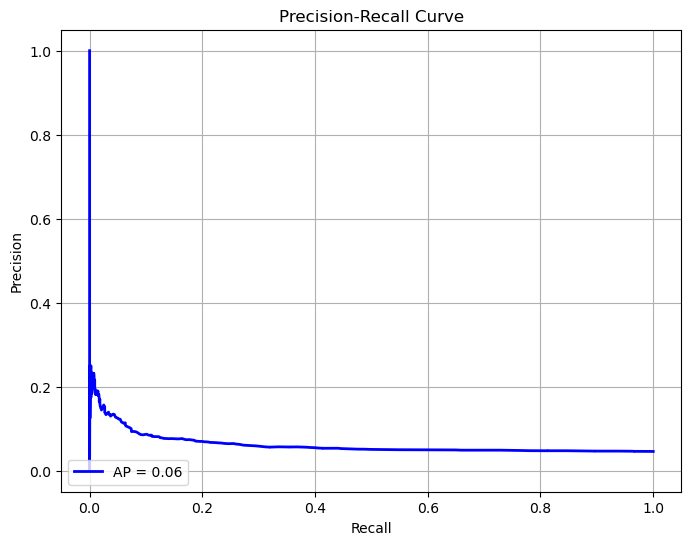

In [218]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

average_precision = average_precision_score(y_test, y_pred_proba)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'AP = {average_precision:.2f}', color='blue', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


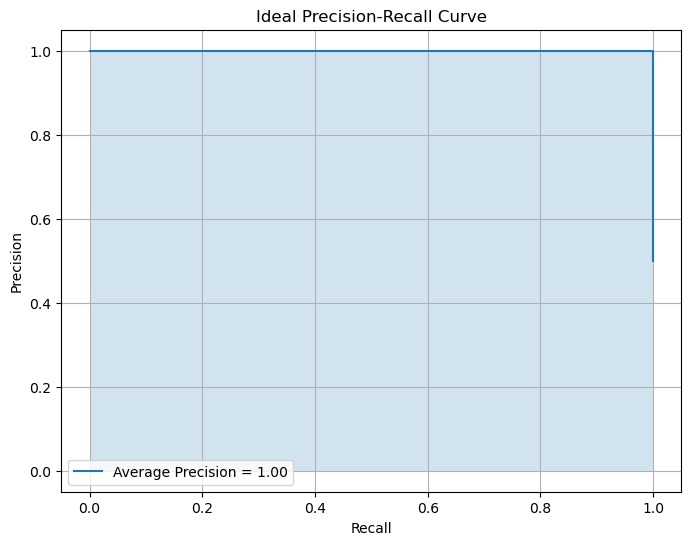

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Create synthetic data for an ideal classifier
# 50 positive samples labeled as 1, 50 negative samples labeled as 0
y_true = np.array([1]*50 + [0]*50)

# Predicted probabilities: all positives have a probability of 1, negatives have 0
y_scores = np.array([1]*50 + [0]*50)

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Calculate average precision score
average_precision = average_precision_score(y_true, y_scores)

# Plotting the Precision-Recall curve
plt.figure(figsize=(8,6))
plt.step(recall, precision, where='post', label=f'Average Precision = {average_precision:.2f}')
plt.fill_between(recall, precision, step='post', alpha=0.2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Ideal Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
